## Introduction

* Sentiment Analysis is the process of detecting the emotion (positive or negative) or perception in a text
* In our case, we want to understand the overall perception of carbon credits in the market, using data from twitter.
* There are various algorithms that can be used to achieve this, but can be generally categorized into 3 broad categories:
    1. **Rule-based systems**, where we use a set of manually crafted rules to help identify the polarity (i.e. negative, positive or neutral) and subjectivity (personal opinion, emotion or judgement) of an text
    1. **Automatics sysytems**, which rely on machine learning techniques to learn from data
    1. **Hybrid sytems**, which combines the two systems above

* The choice of which system to use is dependent on the size of data available and the level of accuracy we need to achieve.
    * While the machine-learning based systems are more often than not more accurate,you do need a lot of data to effectively implement them. 
* Since our data is quite limited, as well as our objective being to estimate the overall perception of carbon credits in the market, we have chosen to use the rule-based system.

### Implementation Steps

The steps in implementing the rule-based systems is as below:
1. Collecting data
    1. Here, we'll first need to create authentication with the Twitter Api
    1. We'll then pull tweets with the tag #carboncredits, using the Twitter API, 
2. Cleaning the tweets
3. Analyzing the tweets
4. Interpreting the results
    1. We will get the overall sentiments in form of the proportion of each polarity to undertand the overall sentiment
    1. We will then look at the word frequency and see if we can get more information

## Importing Libraries

In [1]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
#import pycountry
import re
import string
import requests

#from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from better_profanity import profanity

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antony.rono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Authentication for Twitter API

We first need to get authorized credentials from Twitter to use the API for extracting the tweets.
The steps involve:

   * Creating a [Twitter Developer Account](https://developer.twitter.com/).
   * Creating an app and acquiring the necessary credentials
    
[Reference for obtaining access tokens](https://cran.r-project.org/web/packages/rtweet/vignettes/auth.html)


You will get a  **cosumer key**, **consumer secret**, **access token**,**access token secret** and **bearer token** after registering for the developer account and creating our user application.

In [2]:
# Authentication
consumer_key = "xxxxxxxxxxxxxxxxxxxxxxxx"
consumer_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_token_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
bearer_token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

## Getting Tweets

Now, let's search for tweets about carbon credits. We will exclude retweets and limit the results to a maximum of 100.

You can also include more [parameters](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets)

In [5]:
# Define query, Excluding retweets
query = '#CarbonCredits -is:retweet'

# get max. 100 tweets
tweets = client.search_recent_tweets(query=query, 
                                    tweet_fields=['author_id', 'created_at'],
                                     max_results=100)

print(tweets)

<Response [200]>


Response is 200, meaning that the connection was successful.
Now let's convert the data to a pandas dataframe

In [6]:
#save data as dictiory
tweets_dict = tweets.json()

# Extract "data" value from dictionary
tweets_data = tweets_dict['data'] 

# Transform to pandas Dataframe
df = pd.json_normalize(tweets_data) 

In [7]:
df.head(10)

,created_at,author_id,id,edit_history_tweet_ids,text
0,2023-02-21T01:38:08.000Z,318349748,1627845092248797184,[1627845092248797184],Are #forest carbon offsets a scam or #climate ...
1,2023-02-20T23:06:09.000Z,1380299151213088770,1627806845212708867,[1627806845212708867],No amount of #CarbonCredits or #ESG investment...
2,2023-02-20T21:24:35.000Z,605123503,1627781282196340736,[1627781282196340736],"My colleagues Julie-Anne Lutfi, Graham MacEwan..."
3,2023-02-20T20:59:17.000Z,1564109835213238272,1627774916216098816,[1627774916216098816],You’ll see us listing on one more exchange wit...
4,2023-02-20T20:40:10.000Z,1615935957026365442,1627770106506891265,[1627770106506891265],#15minutecities #15minutecity #15MinutePrisons...
5,2023-02-20T20:17:09.000Z,1306974374214463489,1627764313254514700,[1627764313254514700],#SadiqKhan #ULEZscam #ULEZExpansion #ulez #ltn...
6,2023-02-20T18:31:14.000Z,2612668305,1627737658989416459,[1627737658989416459],Offset YOUR #CarbonFootprint NOW using our Cer...
7,2023-02-20T18:30:45.000Z,2612668305,1627737537430097937,[1627737537430097937],Offset YOUR #CarbonFootprint NOW using our Cer...
8,2023-02-20T18:30:13.000Z,2612668305,1627737401299795974,[1627737401299795974],Offset YOUR #CarbonFootprint NOW using our Cer...
9,2023-02-20T18:29:43.000Z,2612668305,1627737277198700558,[1627737277198700558],Offset YOUR #CarbonFootprint NOW using our Cer...


In [8]:
df.shape

(100, 5)

## Cleaning and Tranforming Tweets

We'll now clean the texts so as to analyze the sentiments

First, we will remove all columns except the one containing the tweets

In [12]:
tweets = df.loc[:,["text"]]
tweets.head()

,text
0,Are #forest carbon offsets a scam or #climate ...
1,No amount of #CarbonCredits or #ESG investment...
2,"My colleagues Julie-Anne Lutfi, Graham MacEwan..."
3,You’ll see us listing on one more exchange wit...
4,#15minutecities #15minutecity #15MinutePrisons...


Next, we will remove the duplicated tweets

In [10]:
#tweets.drop_duplicates("text",keep = "first", inplace = True)
#tweets.reset_index(drop = True)
#tweets = pd.DataFrame(tweets)
#tweets.shape

(100, 1)

Let's now tranlsate the tweets to english using the [tranlsators](https://pypi.org/project/translators/#translate_text) package

In [16]:
import translators as ts

df_translated = []

for i in range(0, df.shape[0]):
    res = ts.translate_text(tweets["text"][i],if_ignore_empty_query=False, if_ignore_limit_of_length=False, limit_of_length=50000, sleep_seconds=5) 
    df_translated.append(res) # Addiing to the list

Finally, let us clean the texts further by removing punctuations, numbers, profanities and stemming the words

In [17]:
tweets["tweets"] = df_translated

tweets.tail(5)

,text,tweets
95,"My colleagues Julie-Anne Lutfi, Graham MacEwan...","My colleagues Julie-Anne Lutfi, Graham MacEwan..."
96,I am very honored and excited to be speaking t...,I am very honored and excited to be speaking t...
97,Saturday satisfied. We are happy to announce ...,Saturday satisfied. We are happy to announce ...
98,Carbon credits are a valuable tool in the figh...,Carbon credits are a valuable tool in the figh...
99,A wide array of programs and markets around th...,A wide array of programs and markets around th...


In [19]:
corpus = []

for i in range(0, tweets.shape[0]):
    review = re.sub("http?://\S+", " ", tweets["tweets"][i]) #Remove links
    #review = re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",tweets["text"][i] )
    review = re.sub("[^a-zA-Z]"," ", review)  #Replace anything that is not a letter by space
    review = review.lower()   #Everything to Lower Case
    review = profanity.censor(review) #Removing Curse Words
    review = review.split()  # Splitting the reviews into their respective words (output is a list)
    ps = PorterStemmer()  #Creating a PorterStemmner Object
    all_stopwords = stopwords.words("english")  # All Stopwords
    all_stopwords.remove("not") # Removing "Not" from the stopwords
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)] #Applying stemming to each of the words that are not stopwords
    review = " ".join(review) # Join the words back together, separated by a space
    corpus.append(review) # Addiing to the list

We then revert the list to a datframe

In [20]:
tweets_df = pd.DataFrame(corpus)
tweets_df.columns = ["tweets"]
tweets_df.tail()

,tweets
95,colleagu juli ann lutfi graham macewan justin ...
96,honor excit speak industri expert knowledg see...
97,saturday satisfi happi announc goal includ gre...
98,carbon credit valuabl tool fight climat chang ...
99,wide array program market around world offer d...


## Sentiment Analysis

Now let's conduct sentiment analysis using rule-based techniques. We will use the [SentimentAnalyzer](https://www.nltk.org/howto/sentiment.html) module from the [nltk](https://www.nltk.org/) package for this.

In [21]:
nltk.download('vader_lexicon')

#Calculating Negative, Positive, Neutral and Compound values
tweets_df[["polarity", "subjectivity"]] = tweets_df["tweets"].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweets_df["tweets"].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score["neg"]
    neg = score["neg"]
    neu = score["neu"]
    pos = score["pos"]
    comp = score["compound"]
    if neg > pos:
        tweets_df.loc[index, "sentiment"] = "negative"
    elif pos > neg:
        tweets_df.loc[index, "sentiment"] = "positive"
    else:
        tweets_df.loc[index, "sentiment"] = "neutral"
        tweets_df.loc[index, "neg"] = neg
        tweets_df.loc[index, "neu"] = neu
        tweets_df.loc[index, "pos"] = pos
        tweets_df.loc[index, "compound"] = comp
tweets_df.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\antony.rono\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweets,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,forest carbon offset scam climat saviour carbo...,0.0,0.0,negative,NaN,NaN,NaN,NaN
1,amount carboncredit esg invest mani plantbas b...,0.0,0.0,positive,NaN,NaN,NaN,NaN
2,colleagu juli ann lutfi graham macewan justin ...,0.0,0.0,negative,NaN,NaN,NaN,NaN
3,see us list one exchang list price doubl curre...,0.0,0.4,neutral,0.0,1.0,0.0,0.0
4,minutec minutec minuteprison minutesc minciti ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
5,sadiqkhan ulezscam ulezexpans ulez ltn ltn caz...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
6,offset carbonfootprint use certifi carboncredi...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
7,offset carbonfootprint use certifi carboncredi...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
8,offset carbonfootprint use certifi carboncredi...,0.0,0.0,positive,NaN,NaN,NaN,NaN
9,offset carbonfootprint use certifi carboncredi...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [24]:
tweets_df.head()

,tweets,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,forest carbon offset scam climat saviour carbo...,0.0,0.0,negative,NaN,NaN,NaN,NaN
1,amount carboncredit esg invest mani plantbas b...,0.0,0.0,positive,NaN,NaN,NaN,NaN
2,colleagu juli ann lutfi graham macewan justin ...,0.0,0.0,negative,NaN,NaN,NaN,NaN
3,see us list one exchang list price doubl curre...,0.0,0.4,neutral,0.0,1.0,0.0,0.0
4,minutec minutec minuteprison minutesc minciti ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


Let's summarize the proportion of each sentiment

In [25]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])

#Count_values for sentiment
count_values_in_column(tweets_df,"sentiment")

,Total,Percentage
neutral,51,51.0
positive,34,34.0
negative,15,15.0


We can also split the dataframe into three different ones, each for each for each sentiment (positive, negative and neutral)

In [26]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tweets_df_negative = tweets_df[tweets_df["sentiment"]=="negative"]
tweets_df_positive = tweets_df[tweets_df["sentiment"]=="positive"]
tweets_df_neutral = tweets_df[tweets_df["sentiment"]=="neutral"]

## Interpretation

We'll visualize the findings of the analysis to better undertand and interpret them

#### Overall Sentiment

First, let us understand the overall sentiment or perception of carbon credits in the market. We'll visuzalize using a pie chart to effectively communicate the proportions

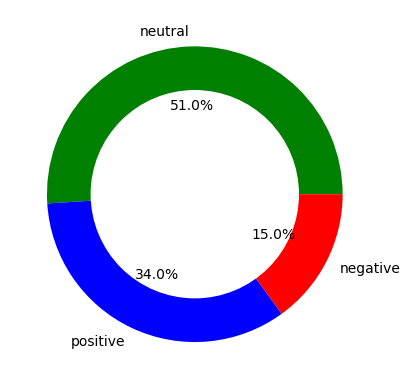

In [27]:
# create data for Pie Chart
pichart = count_values_in_column(tweets_df,"sentiment")
names= pichart.index
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color="white")
plt.pie(size, labels=names, colors=["green","blue","red"],autopct='%.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can see the most of the tweets are either neutral or positive, with the former being slighly more.  

Perharps the reason for the huge number of neutral tweets is marketing/promotional tweets. Let's investigate by looking at the frequency of words

#### Frequency of Words

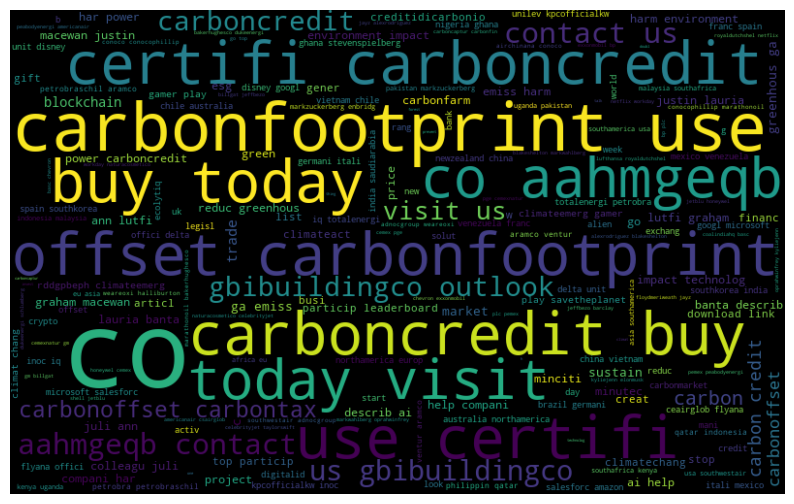

In [28]:
from wordcloud import WordCloud

# Create a Wordcloud from the tweets

all_words = ' '.join([text for text in corpus])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Two observations from the above:
1. There appears to be quite a number of marketing/promotional words like "visit us", "contact", "buy". This confirms our earlier speculation that are lot of tweets are from project developers/brokers marketing their carbon credits 
1. Words that are being used the most are nouns ("Carbon Credit", "offset", "carbon", "C02" etc). This clearly do not bear any significance to what we are trying to achieve.


As a result, we can conclude that:
1. Most of the tweets are mainly for promoting  the carbon credits.
1. For the ones that bear some sentiments, majority of them are positive meaning that the perception of carbon credits in the market is mainly positive.

## References

https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

https://medium.com/@nikitasilaparasetty/twitter-sentiment-analysis-for-data-science-using-python-in-2022-6d5e43f6fa6e

https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/

https://monkeylearn.com/sentiment-analysis/

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:~:text=Polarity%20is%20float%20which%20lies,of%20%5B0%2C1%5D.